 # Part 4: face2face

Setting up the environment and helper functions

In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def imgrid(imarray, cols=5, pad=1):
    if isinstance(imarray, np.ndarray):
        N, H, W, C = imarray.shape
    if isinstance(imarray, list):
        N = len(imarray)
    rows = N // cols + int(N % cols != 0)
    for i in range(N):
        plt.subplot(rows, cols, i+1)
        plt.title("%d"%i)
        plt.imshow(imarray[i])
        plt.axis('off')

Downloading the pre-trained models

In [ ]:
# Use terminal to run wget if notebook hangs

!wget https://dl.dropboxusercontent.com/s/rzfaoeb3e2ta343/face2face_model_epoch_200.zip --no-check-certificate
!unzip face2face_model_epoch_200.zip
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 --no-check-certificate
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
!sudo apt-get install -y cmake
!pip3 install dlib
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz --no-check-certificate
!tar xzf lfw-deepfunneled.tgz

In [3]:
import dlib
import glob
import cv2

In [4]:
tf.reset_default_graph()

In [5]:
graph = tf.Graph()
with graph.as_default():
    with tf.gfile.GFile('frozen_model.pb', 'rb') as model_file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(model_file.read())
        tf.import_graph_def(graph_def, name='')

In [6]:
# Create the face predictor and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

Loading a few images

In [7]:
images = [plt.imread(i) for i in glob.glob('lfw-deepfunneled/lfw-deepfunneled/**/*.jpg')[0:100:10]]

In [7]:
def reshape_for_polyline(array):
    """Reshape image so that it works with polyline."""
    return np.array(array, np.int32).reshape((-1, 1, 2))

def draw_landmarks(gray, face):
    black_image = np.zeros((256,256), np.uint8)
    detected_landmarks = predictor(gray, face).parts()
    landmarks = [[p.x,p.y] for p in detected_landmarks]
    landmarks = landmarks - np.mean(landmarks)
    eye_to_eye = np.linalg.norm(np.mean(landmarks[42:48],axis=0) - np.mean(landmarks[36:42], axis=0))
    scale = eye_to_eye / 22.0
    landmarks = landmarks / scale  + np.array([140,85])

    jaw = reshape_for_polyline(landmarks[0:17])
    left_eyebrow = reshape_for_polyline(landmarks[22:27])
    right_eyebrow = reshape_for_polyline(landmarks[17:22])
    nose_bridge = reshape_for_polyline(landmarks[27:31])
    lower_nose = reshape_for_polyline(landmarks[30:35])
    left_eye = reshape_for_polyline(landmarks[42:48])
    right_eye = reshape_for_polyline(landmarks[36:42])
    outer_lip = reshape_for_polyline(landmarks[48:60])
    inner_lip = reshape_for_polyline(landmarks[60:68])

    color = (255, 255, 255)
    thickness = 2

    cv2.polylines(black_image, [jaw], False, color, thickness)
    cv2.polylines(black_image, [left_eyebrow], False, color, thickness)
    cv2.polylines(black_image, [right_eyebrow], False, color, thickness)
    cv2.polylines(black_image, [nose_bridge], False, color, thickness)
    cv2.polylines(black_image, [lower_nose], True, color, thickness)
    cv2.polylines(black_image, [left_eye], True, color, thickness)
    cv2.polylines(black_image, [right_eye], True, color, thickness)
    cv2.polylines(black_image, [outer_lip], True, color, thickness)
    cv2.polylines(black_image, [inner_lip], True, color, thickness)
    
    return cv2.cvtColor(black_image, cv2.COLOR_GRAY2BGR)

Run the images through the pix2pix model:

In [10]:
outputs = []
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = detector(gray, 1)
    if len(faces) == 0:
        continue

    combined_image = np.concatenate([draw_landmarks(gray, faces[0]), cv2.resize(image,(256,256))], axis=1)
    with tf.Session(graph=graph) as sess:
        generated_image = sess.run('generate_output/output:0', feed_dict={'image_tensor:0': combined_image})
    
    outputs += [combined_image, generated_image[0]]

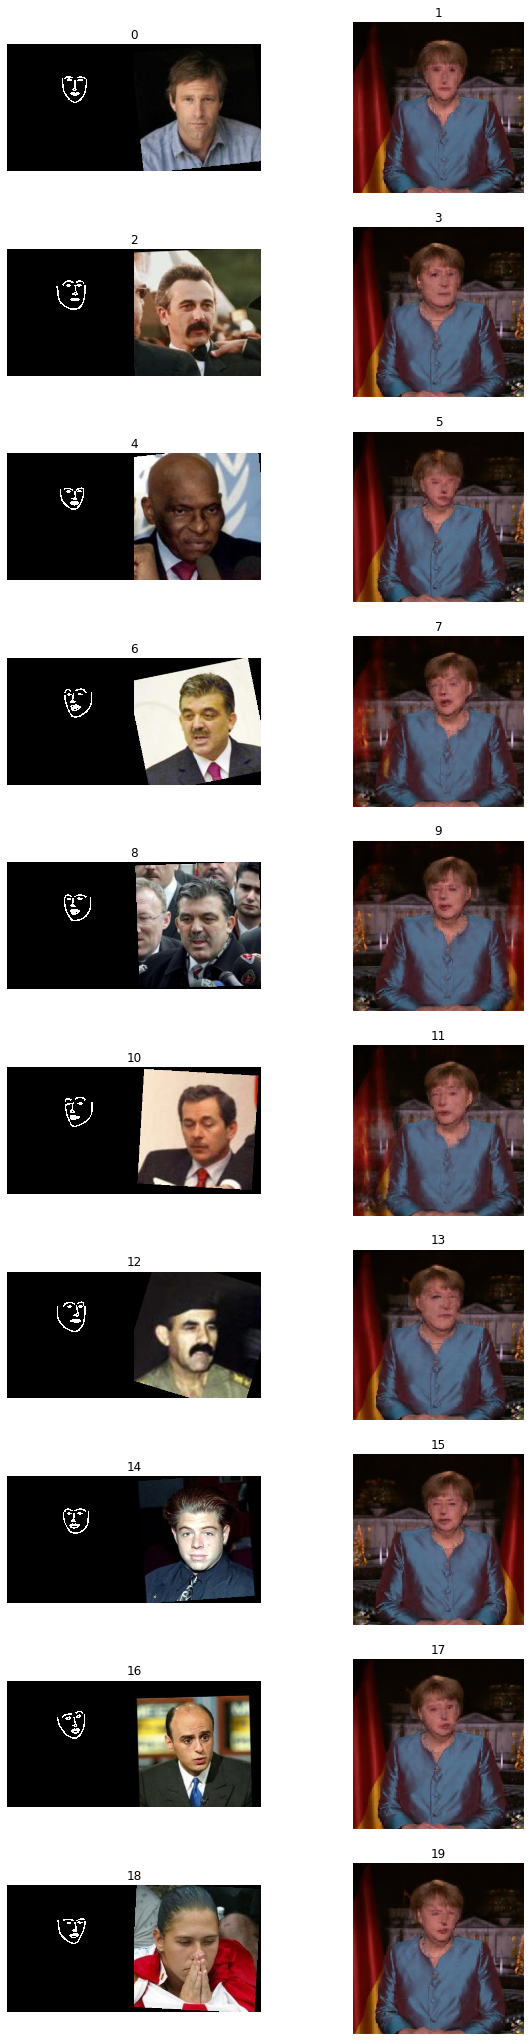

In [11]:
plt.figure(figsize=(10,37));
imgrid(outputs, cols=2);

# Task1:
### Trying out with my own image

In [67]:
def save_frames(vid, folder):
    vidcap = cv2.VideoCapture(vid)
    success,image = vidcap.read()
    count = 0
    while success:
      cv2.imwrite(folder+"frame%d.jpg" % count, image)     # save frame as JPEG file      
      success,image = vidcap.read()
      print('Read a new frame: ', success)
      count += 1
        
def save_video(video_name, img_array):
    layers, height, width, rgb = np.asarray(img_array).shape
    video = cv2.VideoWriter(video_name, 0, 30, (width,height), 1)
    
    for image in img_array:
        video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.destroyAllWindows()
    video.release()

In [9]:
save_frames('myFace/myFace.mp4', "myFace/")

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [9]:
images = [plt.imread('myFace/frame35.jpg')]

In [ ]:
outputs = []

for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = detector(gray, 1)
    if len(faces) == 0:
        continue

    combined_image = np.concatenate([draw_landmarks(gray, faces[0]), cv2.resize(image,(256,256))], axis=1)
    with tf.Session(graph=graph) as sess:
        generated_image = sess.run('generate_output/output:0', feed_dict={'image_tensor:0': combined_image})
    
    outputs += [combined_image, generated_image[0]]
    

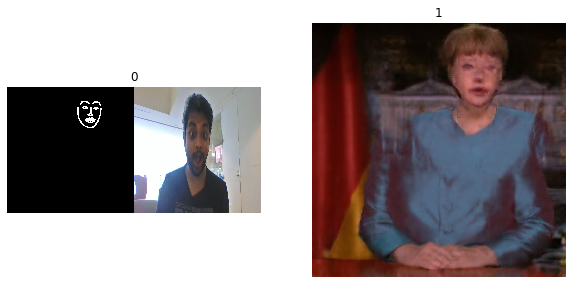

In [11]:
plt.figure(figsize=(10,37));
imgrid(outputs, cols=2);

# Task2 (optional)
## Make a video from face2face output

In [10]:
images = [plt.imread('myFace/frame%d.jpg' % (25+k)) for k in range(20)]

In [11]:
outputs = []
count = 0
for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = detector(gray, 1)
    if len(faces) == 0:
        continue

    combined_image = np.concatenate([draw_landmarks(gray, faces[0]), cv2.resize(image,(256,256))], axis=1)
    with tf.Session(graph=graph) as sess:
        generated_image = sess.run('generate_output/output:0', feed_dict={'image_tensor:0': combined_image})
    
    outputs += [combined_image, generated_image[0]]
    # Saving the generated outputs in a folder. Create this folder if does not exist
    cv2.imwrite('outFace/' + "frame%d.jpg" % count, generated_image[0])
    count+=1

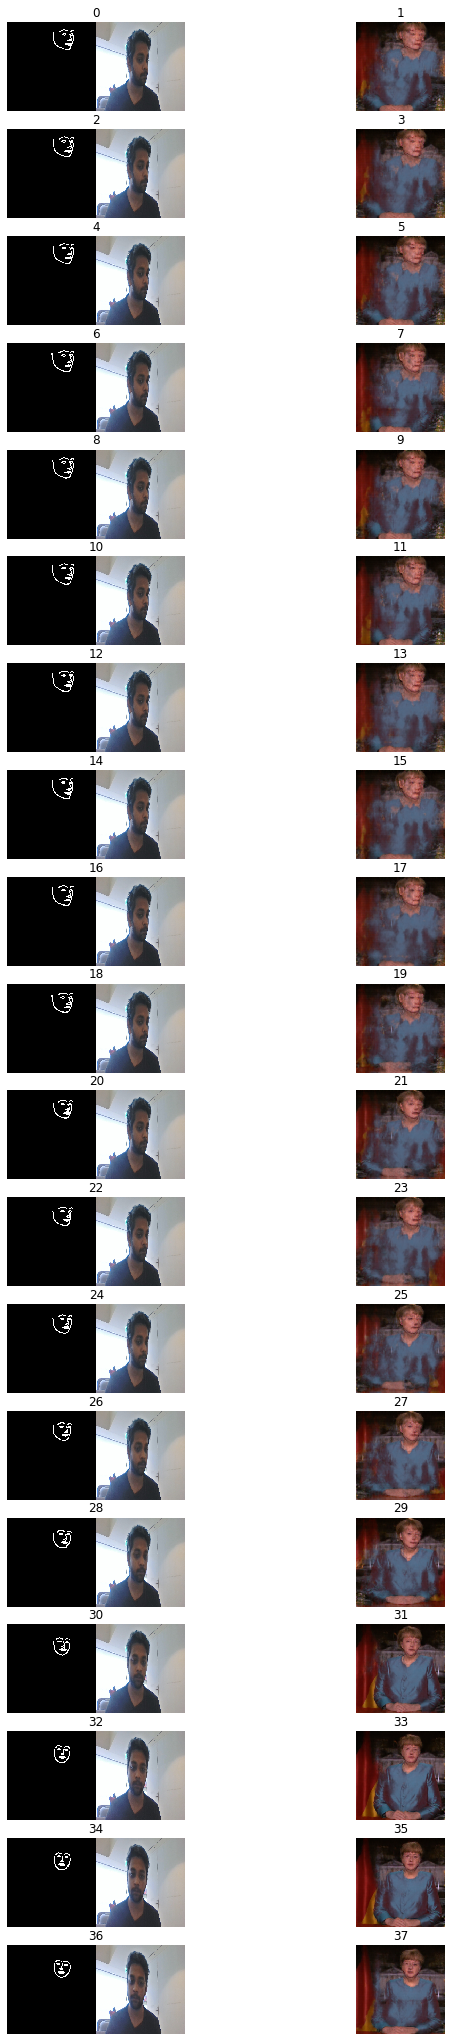

In [13]:
plt.figure(figsize=(10,37));
imgrid(outputs, cols=2);

In [68]:
img_array = [outputs[i] for i in range(38) if i %2 != 0]
save_video('myFace/output.mp4', img_array)

In [69]:
from IPython.display import Video
Video('myFace/output.mp4', width=350, height=300)